In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.

data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv
data/prep/converted_sales_level_12.csv
data/prep/converted_sales_level_11.csv
data/prep/converted_sales_level_10.csv
data/prep/converted_sales_all.csv
data/prep/norm_level_11.csv
data/prep/.DS_Store
data/prep/norm_level_10.csv
data/prep/norm_level_12.csv
data/prep/norm_level_1.csv
data/prep/norm_level_2.csv
data/prep/norm_level_3.csv
data/prep/norm_level_7.csv
data/prep/norm_level_6.csv
data/prep/converted_sales_level_9.csv
data/prep/norm_level_4.csv
data/prep/norm_level_5.csv
data/prep/converted_sales_level_8.csv
data/prep/converted_sales_level_5.csv
data/prep/norm_level_8.csv
data/prep/norm_level_9.csv
data/prep/converted_sales_level_4.csv
data/prep/converted_sales_level_6.csv
data/prep/converted_sales_level_7.csv
data/prep/converted_sales_level_3.csv
data/prep/norm_all.csv
data/prep/converted_sales_leve

In [3]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Pinball Loss function for Keras

In [4]:
train_df = pd.read_csv("custom_layer/features.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets.csv", index_col=0)

In [5]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [6]:
target_df.head()

,0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995
date,,,,,,,,,
2011-01-29,0.429084,0.500587,0.628482,0.662077,0.743227,0.824528,0.861499,0.989619,1.086067
2011-01-30,0.834881,1.032595,1.265410,1.343565,1.503276,1.660740,1.728179,2.014386,2.143587
2011-01-31,0.838167,0.991256,1.246369,1.329488,1.508577,1.680692,1.763780,1.976137,2.167394
2011-02-01,0.424697,0.501162,0.629065,0.668797,0.758173,0.842714,0.878296,1.015888,1.090475
2011-02-02,0.438830,0.511583,0.630601,0.669403,0.754088,0.842727,0.883785,1.007879,1.084537


In [7]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    x = Dense(len(quantiles))(x)  # returns 9 points, one for each quantile
    out = x

    model = Model(inputs=inp, outputs=out)

    return model

In [8]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 27        
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
___________________________________________________________

In [9]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_val, y_val))

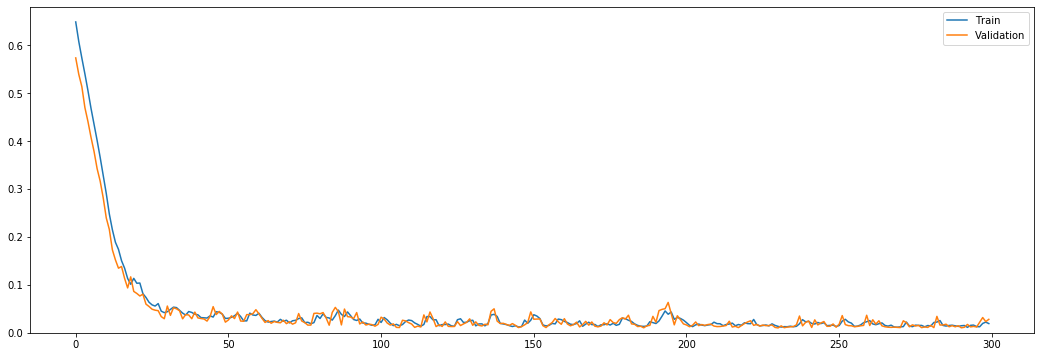

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(X_val)

In [13]:
y_pred[0:2]

array([[0.42877102, 0.50783926, 0.6390131 , 0.67949843, 0.76579404,
        0.8628763 , 0.8989554 , 1.0246816 , 1.1079599 ],
       [0.87215406, 1.0271823 , 1.2731335 , 1.3519785 , 1.5266927 ,
        1.6954639 , 1.772242  , 2.027716  , 2.1654747 ]], dtype=float32)

## Rewrite to multi-output for each quantile

In [14]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    #out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q2 = Dense(1, name="q2")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q3 = Dense(1, name="q3")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q4 = Dense(1, name="q4")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q5 = Dense(1, name="q5")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q6 = Dense(1, name="q6")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q7 = Dense(1, name="q7")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q8 = Dense(1, name="q8")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    
#     out_q0 = DistributionLayer(quantiles[0],x)
#     out_q1 = DistributionLayer(quantiles[1],x)
#     out_q2 = DistributionLayer(quantiles[2],x)
#     out_q3 = DistributionLayer(quantiles[3],x)
#     out_q4 = DistributionLayer(quantiles[4],x)
#     out_q5 = DistributionLayer(quantiles[5],x)
#     out_q6 = DistributionLayer(quantiles[6],x)
#     out_q7 = DistributionLayer(quantiles[7],x)
#     out_q8 = DistributionLayer(quantiles[8],x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [15]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [16]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

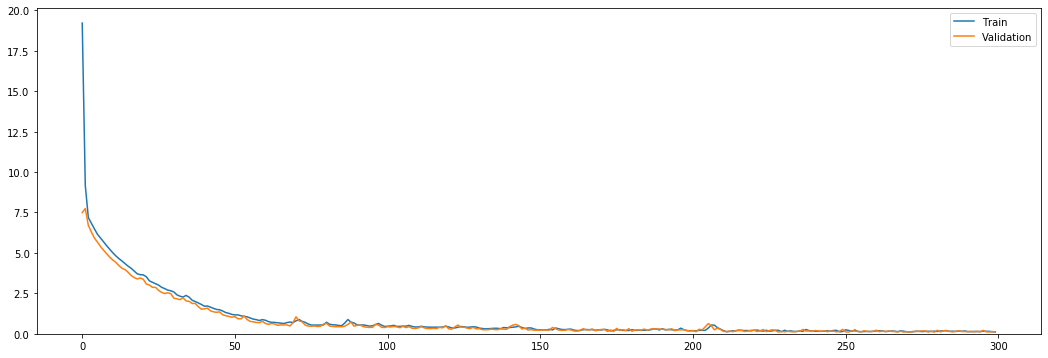

In [18]:
plot_loss(history)

In [19]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.41190457, 0.5099354 , 0.6419455 , 0.66432524, 0.7450259 ,
        0.84716576, 0.8777782 , 1.0259595 , 1.0931804 ],
       [0.85504925, 1.0146873 , 1.2570082 , 1.3277018 , 1.4936616 ,
        1.6699744 , 1.7396986 , 1.9911816 , 2.129536  ]], dtype=float32)

**Note**: training seems slower! 

## Implement custom layer

In [20]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coef):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        return tensor1 + sigma_coef * tensor2

    return custom_layer

def get_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)

    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma

    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [23]:
model = get_dist_model(inp_shape=(train_df.columns.size,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [24]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

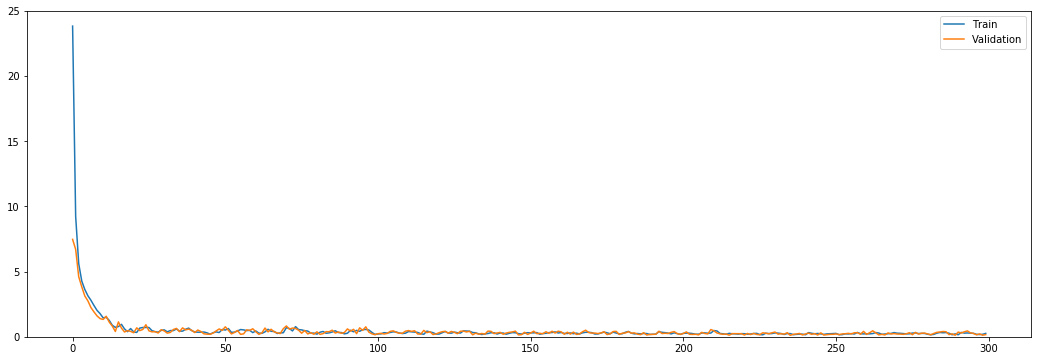

In [26]:
plot_loss(history)

In [27]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.42440388, 0.50361663, 0.63041544, 0.6690158 , 0.75570524,
        0.84239465, 0.88099474, 1.0077939 , 1.0870066 ],
       [0.88190645, 1.0325567 , 1.2737081 , 1.3471202 , 1.5119898 ,
        1.6768595 , 1.7502708 , 1.991423  , 2.1420732 ]], dtype=float32)

## Employ pinball loss

In [30]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [31]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

### With dense layers

In [32]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [33]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 4s 15ms/sample - loss: 10.4412 - q0_loss: 0.9041 - q1_loss: 1.3785 - q2_loss: 0.1196 - q3_loss: 0.4544 - q4_loss: 0.7116 - q5_loss: 1.3039 - q6_loss: 1.4387 - q7_loss: 3.2398 - q8_loss: 0.6115 - val_loss: 6.4173 - val_q0_loss: 0.0150 - val_q1_loss: 0.0924 - val_q2_loss: 0.0656 - val_q3_loss: 0.9118 - val_q4_loss: 1.2135 - val_q5_loss: 0.5130 - val_q6_loss: 3.5438 - val_q7_loss: 0.0832 - val_q8_loss: 0.1891
Epoch 2/300
269/269 [==============================] - 0s 437us/sample - loss: 6.5055 - q0_loss: 0.0146 - q1_loss: 0.0895 - q2_loss: 0.0805 - q3_loss: 0.7782 - q4_loss: 1.2119 - q5_loss: 0.4556 - q6_loss: 3.4890 - q7_loss: 0.0722 - q8_loss: 0.2973 - val_loss: 4.9766 - val_q0_loss: 0.0109 - val_q1_loss: 0.0616 - val_q2_loss: 0.0619 - val_q3_loss: 0.6895 - val_q4_loss: 0.8813 - val_q5_loss: 0.3774 - val_q6_loss: 2.7571 - val_q7_loss: 0.1621 - val_q8_loss: 0.1188
Epoch 3/300
269/269 [====

269/269 [==============================] - 0s 460us/sample - loss: 2.4931 - q0_loss: 0.0064 - q1_loss: 0.0336 - q2_loss: 0.0537 - q3_loss: 0.0305 - q4_loss: 0.5033 - q5_loss: 0.0398 - q6_loss: 1.5614 - q7_loss: 0.2646 - q8_loss: 0.0264 - val_loss: 2.2825 - val_q0_loss: 0.0057 - val_q1_loss: 0.0311 - val_q2_loss: 0.0485 - val_q3_loss: 0.0377 - val_q4_loss: 0.4566 - val_q5_loss: 0.0199 - val_q6_loss: 1.3607 - val_q7_loss: 0.1208 - val_q8_loss: 0.0654
Epoch 19/300
269/269 [==============================] - 0s 450us/sample - loss: 2.4243 - q0_loss: 0.0064 - q1_loss: 0.0335 - q2_loss: 0.0485 - q3_loss: 0.0284 - q4_loss: 0.4887 - q5_loss: 0.0411 - q6_loss: 1.5423 - q7_loss: 0.2141 - q8_loss: 0.0197 - val_loss: 2.2357 - val_q0_loss: 0.0056 - val_q1_loss: 0.0283 - val_q2_loss: 0.0326 - val_q3_loss: 0.0192 - val_q4_loss: 0.3961 - val_q5_loss: 0.0492 - val_q6_loss: 1.3385 - val_q7_loss: 0.2306 - val_q8_loss: 0.0017
Epoch 20/300
269/269 [==============================] - 0s 450us/sample - loss: 2

Epoch 36/300
269/269 [==============================] - 0s 408us/sample - loss: 1.6139 - q0_loss: 0.0059 - q1_loss: 0.0274 - q2_loss: 0.0252 - q3_loss: 0.0188 - q4_loss: 0.2282 - q5_loss: 0.0243 - q6_loss: 1.1203 - q7_loss: 0.1496 - q8_loss: 0.0025 - val_loss: 1.4185 - val_q0_loss: 0.0053 - val_q1_loss: 0.0263 - val_q2_loss: 0.0178 - val_q3_loss: 0.0191 - val_q4_loss: 0.2277 - val_q5_loss: 0.0125 - val_q6_loss: 1.0026 - val_q7_loss: 9.5981e-04 - val_q8_loss: 0.0012
Epoch 37/300
269/269 [==============================] - 0s 401us/sample - loss: 1.5167 - q0_loss: 0.0061 - q1_loss: 0.0289 - q2_loss: 0.0234 - q3_loss: 0.0174 - q4_loss: 0.2368 - q5_loss: 0.0203 - q6_loss: 1.1426 - q7_loss: 0.0475 - q8_loss: 0.0022 - val_loss: 1.3299 - val_q0_loss: 0.0053 - val_q1_loss: 0.0250 - val_q2_loss: 0.0136 - val_q3_loss: 0.0106 - val_q4_loss: 0.1862 - val_q5_loss: 0.0104 - val_q6_loss: 0.9601 - val_q7_loss: 0.0083 - val_q8_loss: 0.0019
Epoch 38/300
269/269 [==============================] - 0s 402us

Epoch 54/300
269/269 [==============================] - 0s 411us/sample - loss: 0.6665 - q0_loss: 0.0055 - q1_loss: 0.0187 - q2_loss: 0.0126 - q3_loss: 0.0176 - q4_loss: 0.0621 - q5_loss: 0.0250 - q6_loss: 0.4792 - q7_loss: 0.0406 - q8_loss: 0.0063 - val_loss: 0.5793 - val_q0_loss: 0.0045 - val_q1_loss: 0.0138 - val_q2_loss: 0.0084 - val_q3_loss: 0.0228 - val_q4_loss: 0.0772 - val_q5_loss: 0.0302 - val_q6_loss: 0.3045 - val_q7_loss: 0.0582 - val_q8_loss: 0.0055
Epoch 55/300
269/269 [==============================] - 0s 400us/sample - loss: 0.5908 - q0_loss: 0.0053 - q1_loss: 0.0168 - q2_loss: 0.0115 - q3_loss: 0.0186 - q4_loss: 0.0743 - q5_loss: 0.0233 - q6_loss: 0.3902 - q7_loss: 0.0338 - q8_loss: 0.0067 - val_loss: 0.4737 - val_q0_loss: 0.0046 - val_q1_loss: 0.0140 - val_q2_loss: 0.0067 - val_q3_loss: 0.0184 - val_q4_loss: 0.0828 - val_q5_loss: 0.0116 - val_q6_loss: 0.2740 - val_q7_loss: 0.0082 - val_q8_loss: 0.0060
Epoch 56/300
269/269 [==============================] - 0s 399us/sam

Epoch 72/300
269/269 [==============================] - 0s 394us/sample - loss: 0.0995 - q0_loss: 0.0054 - q1_loss: 0.0111 - q2_loss: 0.0097 - q3_loss: 0.0101 - q4_loss: 0.0182 - q5_loss: 0.0115 - q6_loss: 0.0151 - q7_loss: 0.0102 - q8_loss: 0.0095 - val_loss: 0.1474 - val_q0_loss: 0.0046 - val_q1_loss: 0.0071 - val_q2_loss: 0.0155 - val_q3_loss: 0.0060 - val_q4_loss: 0.0540 - val_q5_loss: 0.0057 - val_q6_loss: 0.0339 - val_q7_loss: 0.0114 - val_q8_loss: 0.0093
Epoch 73/300
269/269 [==============================] - 0s 398us/sample - loss: 0.1179 - q0_loss: 0.0054 - q1_loss: 0.0099 - q2_loss: 0.0087 - q3_loss: 0.0081 - q4_loss: 0.0305 - q5_loss: 0.0081 - q6_loss: 0.0229 - q7_loss: 0.0115 - q8_loss: 0.0099 - val_loss: 0.1328 - val_q0_loss: 0.0051 - val_q1_loss: 0.0124 - val_q2_loss: 0.0097 - val_q3_loss: 0.0104 - val_q4_loss: 0.0365 - val_q5_loss: 0.0055 - val_q6_loss: 0.0366 - val_q7_loss: 0.0123 - val_q8_loss: 0.0075
Epoch 74/300
269/269 [==============================] - 0s 400us/sam

Epoch 90/300
269/269 [==============================] - 0s 402us/sample - loss: 0.0652 - q0_loss: 0.0052 - q1_loss: 0.0056 - q2_loss: 0.0043 - q3_loss: 0.0075 - q4_loss: 0.0061 - q5_loss: 0.0100 - q6_loss: 0.0077 - q7_loss: 0.0092 - q8_loss: 0.0095 - val_loss: 0.0594 - val_q0_loss: 0.0048 - val_q1_loss: 0.0060 - val_q2_loss: 0.0030 - val_q3_loss: 0.0041 - val_q4_loss: 0.0058 - val_q5_loss: 0.0099 - val_q6_loss: 0.0055 - val_q7_loss: 0.0116 - val_q8_loss: 0.0082
Epoch 91/300
269/269 [==============================] - 0s 400us/sample - loss: 0.0591 - q0_loss: 0.0052 - q1_loss: 0.0055 - q2_loss: 0.0035 - q3_loss: 0.0056 - q4_loss: 0.0062 - q5_loss: 0.0074 - q6_loss: 0.0064 - q7_loss: 0.0095 - q8_loss: 0.0094 - val_loss: 0.0528 - val_q0_loss: 0.0048 - val_q1_loss: 0.0056 - val_q2_loss: 0.0029 - val_q3_loss: 0.0034 - val_q4_loss: 0.0034 - val_q5_loss: 0.0075 - val_q6_loss: 0.0061 - val_q7_loss: 0.0114 - val_q8_loss: 0.0082
Epoch 92/300
269/269 [==============================] - 0s 388us/sam

Epoch 108/300
269/269 [==============================] - 0s 394us/sample - loss: 0.0596 - q0_loss: 0.0050 - q1_loss: 0.0030 - q2_loss: 0.0030 - q3_loss: 0.0044 - q4_loss: 0.0097 - q5_loss: 0.0058 - q6_loss: 0.0100 - q7_loss: 0.0091 - q8_loss: 0.0093 - val_loss: 0.0590 - val_q0_loss: 0.0045 - val_q1_loss: 0.0042 - val_q2_loss: 0.0025 - val_q3_loss: 0.0030 - val_q4_loss: 0.0129 - val_q5_loss: 0.0070 - val_q6_loss: 0.0061 - val_q7_loss: 0.0115 - val_q8_loss: 0.0078
Epoch 109/300
269/269 [==============================] - 0s 424us/sample - loss: 0.0539 - q0_loss: 0.0049 - q1_loss: 0.0030 - q2_loss: 0.0028 - q3_loss: 0.0036 - q4_loss: 0.0089 - q5_loss: 0.0046 - q6_loss: 0.0080 - q7_loss: 0.0088 - q8_loss: 0.0092 - val_loss: 0.0484 - val_q0_loss: 0.0045 - val_q1_loss: 0.0038 - val_q2_loss: 0.0026 - val_q3_loss: 0.0025 - val_q4_loss: 0.0091 - val_q5_loss: 0.0039 - val_q6_loss: 0.0032 - val_q7_loss: 0.0110 - val_q8_loss: 0.0078
Epoch 110/300
269/269 [==============================] - 0s 411us/

Epoch 126/300
269/269 [==============================] - 0s 414us/sample - loss: 0.0577 - q0_loss: 0.0046 - q1_loss: 0.0046 - q2_loss: 0.0035 - q3_loss: 0.0060 - q4_loss: 0.0059 - q5_loss: 0.0097 - q6_loss: 0.0059 - q7_loss: 0.0094 - q8_loss: 0.0087 - val_loss: 0.0600 - val_q0_loss: 0.0041 - val_q1_loss: 0.0037 - val_q2_loss: 0.0018 - val_q3_loss: 0.0037 - val_q4_loss: 0.0124 - val_q5_loss: 0.0056 - val_q6_loss: 0.0102 - val_q7_loss: 0.0101 - val_q8_loss: 0.0078
Epoch 127/300
269/269 [==============================] - 0s 424us/sample - loss: 0.0642 - q0_loss: 0.0046 - q1_loss: 0.0040 - q2_loss: 0.0029 - q3_loss: 0.0048 - q4_loss: 0.0126 - q5_loss: 0.0066 - q6_loss: 0.0104 - q7_loss: 0.0096 - q8_loss: 0.0089 - val_loss: 0.0596 - val_q0_loss: 0.0041 - val_q1_loss: 0.0033 - val_q2_loss: 0.0031 - val_q3_loss: 0.0029 - val_q4_loss: 0.0143 - val_q5_loss: 0.0042 - val_q6_loss: 0.0116 - val_q7_loss: 0.0101 - val_q8_loss: 0.0078
Epoch 128/300
269/269 [==============================] - 0s 403us/

Epoch 144/300
269/269 [==============================] - 0s 416us/sample - loss: 0.0551 - q0_loss: 0.0043 - q1_loss: 0.0030 - q2_loss: 0.0037 - q3_loss: 0.0056 - q4_loss: 0.0057 - q5_loss: 0.0073 - q6_loss: 0.0070 - q7_loss: 0.0094 - q8_loss: 0.0086 - val_loss: 0.0496 - val_q0_loss: 0.0038 - val_q1_loss: 0.0029 - val_q2_loss: 0.0037 - val_q3_loss: 0.0053 - val_q4_loss: 0.0068 - val_q5_loss: 0.0040 - val_q6_loss: 0.0049 - val_q7_loss: 0.0104 - val_q8_loss: 0.0072
Epoch 145/300
269/269 [==============================] - 0s 426us/sample - loss: 0.0520 - q0_loss: 0.0042 - q1_loss: 0.0027 - q2_loss: 0.0033 - q3_loss: 0.0044 - q4_loss: 0.0078 - q5_loss: 0.0054 - q6_loss: 0.0064 - q7_loss: 0.0090 - q8_loss: 0.0085 - val_loss: 0.0532 - val_q0_loss: 0.0038 - val_q1_loss: 0.0026 - val_q2_loss: 0.0048 - val_q3_loss: 0.0063 - val_q4_loss: 0.0050 - val_q5_loss: 0.0075 - val_q6_loss: 0.0067 - val_q7_loss: 0.0109 - val_q8_loss: 0.0076
Epoch 146/300
269/269 [==============================] - 0s 414us/

Epoch 162/300
269/269 [==============================] - 0s 406us/sample - loss: 0.1351 - q0_loss: 0.0039 - q1_loss: 0.0081 - q2_loss: 0.0042 - q3_loss: 0.0154 - q4_loss: 0.0254 - q5_loss: 0.0230 - q6_loss: 0.0346 - q7_loss: 0.0142 - q8_loss: 0.0083 - val_loss: 0.1683 - val_q0_loss: 0.0039 - val_q1_loss: 0.0067 - val_q2_loss: 0.0024 - val_q3_loss: 0.0210 - val_q4_loss: 0.0302 - val_q5_loss: 0.0255 - val_q6_loss: 0.0564 - val_q7_loss: 0.0150 - val_q8_loss: 0.0073
Epoch 163/300
269/269 [==============================] - 0s 402us/sample - loss: 0.0960 - q0_loss: 0.0039 - q1_loss: 0.0045 - q2_loss: 0.0029 - q3_loss: 0.0106 - q4_loss: 0.0178 - q5_loss: 0.0164 - q6_loss: 0.0195 - q7_loss: 0.0102 - q8_loss: 0.0085 - val_loss: 0.0789 - val_q0_loss: 0.0033 - val_q1_loss: 0.0034 - val_q2_loss: 0.0052 - val_q3_loss: 0.0146 - val_q4_loss: 0.0070 - val_q5_loss: 0.0149 - val_q6_loss: 0.0161 - val_q7_loss: 0.0088 - val_q8_loss: 0.0070
Epoch 164/300
269/269 [==============================] - 0s 411us/

Epoch 180/300
269/269 [==============================] - 0s 414us/sample - loss: 0.0574 - q0_loss: 0.0035 - q1_loss: 0.0034 - q2_loss: 0.0044 - q3_loss: 0.0054 - q4_loss: 0.0093 - q5_loss: 0.0064 - q6_loss: 0.0074 - q7_loss: 0.0087 - q8_loss: 0.0079 - val_loss: 0.0742 - val_q0_loss: 0.0030 - val_q1_loss: 0.0033 - val_q2_loss: 0.0062 - val_q3_loss: 0.0098 - val_q4_loss: 0.0086 - val_q5_loss: 0.0207 - val_q6_loss: 0.0063 - val_q7_loss: 0.0089 - val_q8_loss: 0.0063
Epoch 181/300
269/269 [==============================] - 0s 404us/sample - loss: 0.0587 - q0_loss: 0.0034 - q1_loss: 0.0031 - q2_loss: 0.0035 - q3_loss: 0.0070 - q4_loss: 0.0077 - q5_loss: 0.0100 - q6_loss: 0.0068 - q7_loss: 0.0092 - q8_loss: 0.0077 - val_loss: 0.0586 - val_q0_loss: 0.0029 - val_q1_loss: 0.0022 - val_q2_loss: 0.0048 - val_q3_loss: 0.0096 - val_q4_loss: 0.0049 - val_q5_loss: 0.0099 - val_q6_loss: 0.0087 - val_q7_loss: 0.0088 - val_q8_loss: 0.0065
Epoch 182/300
269/269 [==============================] - 0s 412us/

Epoch 198/300
269/269 [==============================] - 0s 402us/sample - loss: 0.0853 - q0_loss: 0.0030 - q1_loss: 0.0041 - q2_loss: 0.0062 - q3_loss: 0.0085 - q4_loss: 0.0181 - q5_loss: 0.0135 - q6_loss: 0.0149 - q7_loss: 0.0092 - q8_loss: 0.0075 - val_loss: 0.0647 - val_q0_loss: 0.0025 - val_q1_loss: 0.0026 - val_q2_loss: 0.0037 - val_q3_loss: 0.0077 - val_q4_loss: 0.0072 - val_q5_loss: 0.0108 - val_q6_loss: 0.0140 - val_q7_loss: 0.0090 - val_q8_loss: 0.0065
Epoch 199/300
269/269 [==============================] - 0s 401us/sample - loss: 0.0611 - q0_loss: 0.0030 - q1_loss: 0.0034 - q2_loss: 0.0037 - q3_loss: 0.0054 - q4_loss: 0.0106 - q5_loss: 0.0065 - q6_loss: 0.0110 - q7_loss: 0.0091 - q8_loss: 0.0075 - val_loss: 0.0580 - val_q0_loss: 0.0027 - val_q1_loss: 0.0040 - val_q2_loss: 0.0055 - val_q3_loss: 0.0078 - val_q4_loss: 0.0116 - val_q5_loss: 0.0037 - val_q6_loss: 0.0059 - val_q7_loss: 0.0101 - val_q8_loss: 0.0061
Epoch 200/300
269/269 [==============================] - 0s 409us/

Epoch 216/300
269/269 [==============================] - 0s 448us/sample - loss: 0.0663 - q0_loss: 0.0025 - q1_loss: 0.0034 - q2_loss: 0.0027 - q3_loss: 0.0077 - q4_loss: 0.0121 - q5_loss: 0.0110 - q6_loss: 0.0163 - q7_loss: 0.0094 - q8_loss: 0.0071 - val_loss: 0.0602 - val_q0_loss: 0.0022 - val_q1_loss: 0.0027 - val_q2_loss: 0.0033 - val_q3_loss: 0.0061 - val_q4_loss: 0.0085 - val_q5_loss: 0.0095 - val_q6_loss: 0.0093 - val_q7_loss: 0.0097 - val_q8_loss: 0.0059
Epoch 217/300
269/269 [==============================] - 0s 448us/sample - loss: 0.0701 - q0_loss: 0.0024 - q1_loss: 0.0040 - q2_loss: 0.0026 - q3_loss: 0.0069 - q4_loss: 0.0120 - q5_loss: 0.0121 - q6_loss: 0.0123 - q7_loss: 0.0093 - q8_loss: 0.0072 - val_loss: 0.1081 - val_q0_loss: 0.0025 - val_q1_loss: 0.0051 - val_q2_loss: 0.0032 - val_q3_loss: 0.0118 - val_q4_loss: 0.0212 - val_q5_loss: 0.0190 - val_q6_loss: 0.0326 - val_q7_loss: 0.0132 - val_q8_loss: 0.0060
Epoch 218/300
269/269 [==============================] - 0s 456us/

Epoch 234/300
269/269 [==============================] - 0s 422us/sample - loss: 0.0657 - q0_loss: 0.0020 - q1_loss: 0.0027 - q2_loss: 0.0037 - q3_loss: 0.0080 - q4_loss: 0.0100 - q5_loss: 0.0115 - q6_loss: 0.0110 - q7_loss: 0.0088 - q8_loss: 0.0067 - val_loss: 0.0807 - val_q0_loss: 0.0015 - val_q1_loss: 0.0052 - val_q2_loss: 0.0043 - val_q3_loss: 0.0111 - val_q4_loss: 0.0106 - val_q5_loss: 0.0184 - val_q6_loss: 0.0123 - val_q7_loss: 0.0112 - val_q8_loss: 0.0055
Epoch 235/300
269/269 [==============================] - 0s 418us/sample - loss: 0.0530 - q0_loss: 0.0019 - q1_loss: 0.0027 - q2_loss: 0.0030 - q3_loss: 0.0058 - q4_loss: 0.0071 - q5_loss: 0.0085 - q6_loss: 0.0076 - q7_loss: 0.0090 - q8_loss: 0.0066 - val_loss: 0.0491 - val_q0_loss: 0.0018 - val_q1_loss: 0.0034 - val_q2_loss: 0.0024 - val_q3_loss: 0.0032 - val_q4_loss: 0.0095 - val_q5_loss: 0.0079 - val_q6_loss: 0.0057 - val_q7_loss: 0.0107 - val_q8_loss: 0.0055
Epoch 236/300
269/269 [==============================] - 0s 405us/

Epoch 252/300
269/269 [==============================] - 0s 445us/sample - loss: 0.0491 - q0_loss: 0.0014 - q1_loss: 0.0021 - q2_loss: 0.0031 - q3_loss: 0.0040 - q4_loss: 0.0090 - q5_loss: 0.0060 - q6_loss: 0.0092 - q7_loss: 0.0076 - q8_loss: 0.0061 - val_loss: 0.0424 - val_q0_loss: 0.0011 - val_q1_loss: 0.0017 - val_q2_loss: 0.0036 - val_q3_loss: 0.0059 - val_q4_loss: 0.0042 - val_q5_loss: 0.0070 - val_q6_loss: 0.0074 - val_q7_loss: 0.0079 - val_q8_loss: 0.0051
Epoch 253/300
269/269 [==============================] - 0s 429us/sample - loss: 0.0397 - q0_loss: 0.0013 - q1_loss: 0.0021 - q2_loss: 0.0028 - q3_loss: 0.0045 - q4_loss: 0.0042 - q5_loss: 0.0059 - q6_loss: 0.0046 - q7_loss: 0.0078 - q8_loss: 0.0061 - val_loss: 0.0342 - val_q0_loss: 0.0012 - val_q1_loss: 0.0023 - val_q2_loss: 0.0027 - val_q3_loss: 0.0038 - val_q4_loss: 0.0034 - val_q5_loss: 0.0048 - val_q6_loss: 0.0028 - val_q7_loss: 0.0093 - val_q8_loss: 0.0052
Epoch 254/300
269/269 [==============================] - 0s 450us/

269/269 [==============================] - 0s 445us/sample - loss: 0.0354 - q0_loss: 7.8964e-04 - q1_loss: 0.0017 - q2_loss: 0.0028 - q3_loss: 0.0044 - q4_loss: 0.0042 - q5_loss: 0.0044 - q6_loss: 0.0039 - q7_loss: 0.0075 - q8_loss: 0.0057 - val_loss: 0.0353 - val_q0_loss: 6.5527e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.0032 - val_q3_loss: 0.0039 - val_q4_loss: 0.0035 - val_q5_loss: 0.0054 - val_q6_loss: 0.0035 - val_q7_loss: 0.0091 - val_q8_loss: 0.0049
Epoch 270/300
269/269 [==============================] - 0s 386us/sample - loss: 0.0479 - q0_loss: 7.6311e-04 - q1_loss: 0.0020 - q2_loss: 0.0035 - q3_loss: 0.0051 - q4_loss: 0.0069 - q5_loss: 0.0071 - q6_loss: 0.0085 - q7_loss: 0.0085 - q8_loss: 0.0056 - val_loss: 0.0620 - val_q0_loss: 4.1694e-04 - val_q1_loss: 0.0107 - val_q2_loss: 0.0024 - val_q3_loss: 0.0043 - val_q4_loss: 0.0152 - val_q5_loss: 0.0099 - val_q6_loss: 0.0112 - val_q7_loss: 0.0082 - val_q8_loss: 0.0049
Epoch 271/300
269/269 [==============================] - 0s 404u

269/269 [==============================] - 0s 384us/sample - loss: 0.0413 - q0_loss: 6.9525e-04 - q1_loss: 0.0026 - q2_loss: 0.0030 - q3_loss: 0.0051 - q4_loss: 0.0054 - q5_loss: 0.0055 - q6_loss: 0.0058 - q7_loss: 0.0077 - q8_loss: 0.0052 - val_loss: 0.0416 - val_q0_loss: 5.5252e-04 - val_q1_loss: 0.0024 - val_q2_loss: 0.0038 - val_q3_loss: 0.0041 - val_q4_loss: 0.0062 - val_q5_loss: 0.0057 - val_q6_loss: 0.0061 - val_q7_loss: 0.0090 - val_q8_loss: 0.0045
Epoch 287/300
269/269 [==============================] - 0s 405us/sample - loss: 0.0377 - q0_loss: 6.6801e-04 - q1_loss: 0.0025 - q2_loss: 0.0032 - q3_loss: 0.0041 - q4_loss: 0.0060 - q5_loss: 0.0042 - q6_loss: 0.0047 - q7_loss: 0.0077 - q8_loss: 0.0051 - val_loss: 0.0530 - val_q0_loss: 3.9267e-04 - val_q1_loss: 0.0016 - val_q2_loss: 0.0028 - val_q3_loss: 0.0050 - val_q4_loss: 0.0112 - val_q5_loss: 0.0117 - val_q6_loss: 0.0088 - val_q7_loss: 0.0074 - val_q8_loss: 0.0043
Epoch 288/300
269/269 [==============================] - 0s 392u

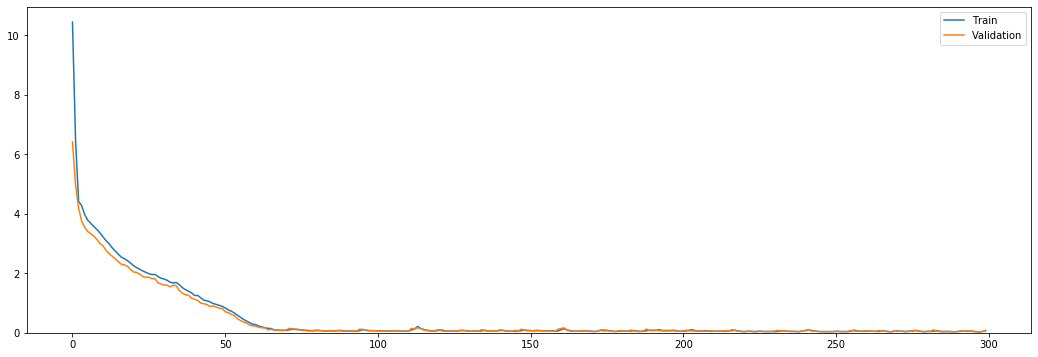

In [34]:
plot_loss(history)

In [35]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.363517  , 0.44887525, 0.6068511 , 0.64339674, 0.76303583,
        0.8477015 , 0.9314115 , 1.3485146 , 1.705644  ],
       [0.6785099 , 0.9857897 , 1.2596438 , 1.3432251 , 1.5398378 ,
        1.7359878 , 1.8224201 , 2.0826895 , 4.0149703 ]], dtype=float32)

### With distribution layer

In [36]:
model = get_dist_model(inp_shape=(train_df.columns.size,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

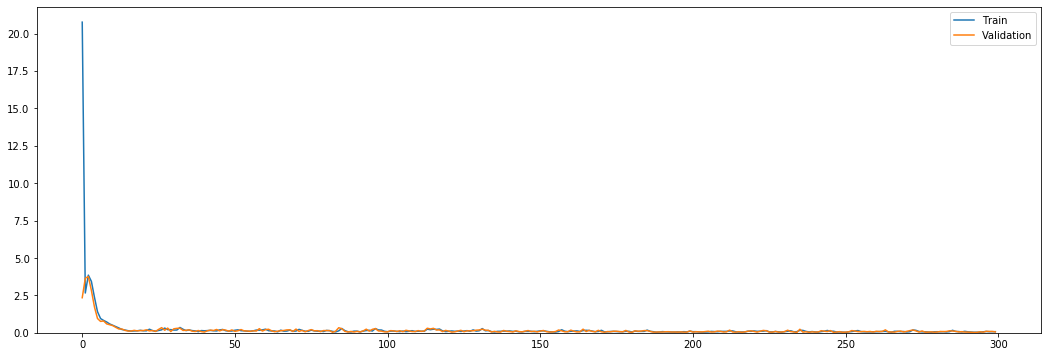

In [38]:
plot_loss(history)

In [39]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.3300553 , 0.42583632, 0.57915664, 0.6258308 , 0.73065233,
        0.83547384, 0.88214767, 1.0354683 , 1.1312494 ],
       [0.7002827 , 0.8891107 , 1.1913747 , 1.2833908 , 1.4900416 ,
        1.6966925 , 1.7887077 , 2.0909724 , 2.2798004 ]], dtype=float32)

**Note**: the distribution of predictions is wider than when trained with the MAE. This is in line with what we would expect: over-predicting the lower quantiles is punished much harder than before, and the same for under-predicting the higher quantiles.

## Test pinball loss

In [40]:
# from https://github.com/keras-team/keras/pull/8033/files
def test_pinball_loss():
    y_pred = K.variable(np.array([0.3, 0.6, 0.1]))
    y_true = K.variable(np.array([0.3, 0.4, 0.5]))
    quantile = 0.25
    loss_fcn = create_pinball_loss(tau=quantile)#losses.PinballLoss(quantile)
    expected_loss = (quantile * 0.4 + (1 - quantile) * 0.2) / 3
    loss = K.eval(loss_fcn(y_true, y_pred))
    assert np.isclose(expected_loss, loss)

test_pinball_loss()

## Dataset 2

In [41]:
train_df = pd.read_csv("custom_layer/features2.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets2.csv", index_col=0, header=None, names=['target'])
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [42]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [43]:
target_df.head()

,target
2011-01-29,0.751272
2011-01-30,1.175314
2011-01-31,1.527411
2011-02-01,0.952662
2011-02-02,0.595021


In [44]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [45]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_mo = {'q'+str(i): y_train for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val for i in range(len(quantiles))}

In [46]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

### With dense layers

In [47]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[1])(x)
    out_q2 = Dense(1, name="q2")(x)  # ...
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [48]:
model = get_model(inp_shape=(X_train.shape[1],), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

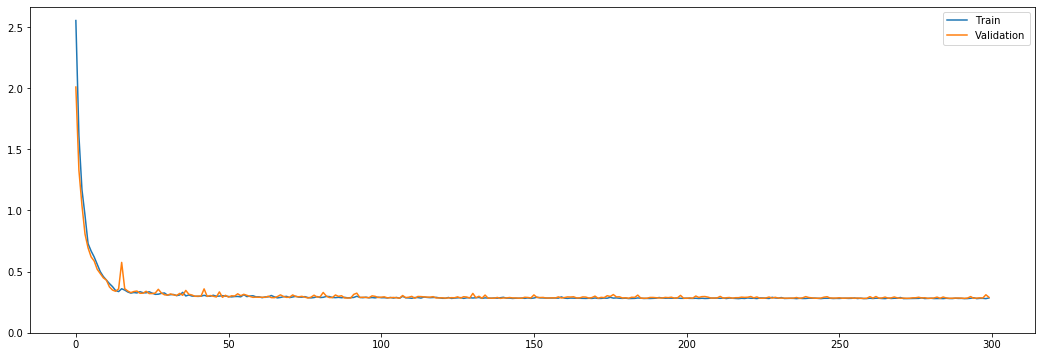

In [50]:
plot_loss(history)

**Predicted distribution**

In [51]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.43056595, 0.50606185, 0.60691816, 0.65994996, 0.743345  ,
        0.824427  , 0.86962   , 1.025811  , 1.097844  ],
       [0.87028414, 0.94503164, 1.1406838 , 1.2449015 , 1.390889  ,
        1.5505037 , 1.6440178 , 1.9353397 , 2.0873573 ]], dtype=float32)

### With distribution layer

In [52]:
model = get_dist_model(inp_shape=(X_train.shape[1],), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
history_dist = model.fit(X_train, y_train_mo, epochs=300,
                         validation_data=(X_val, y_val_mo))

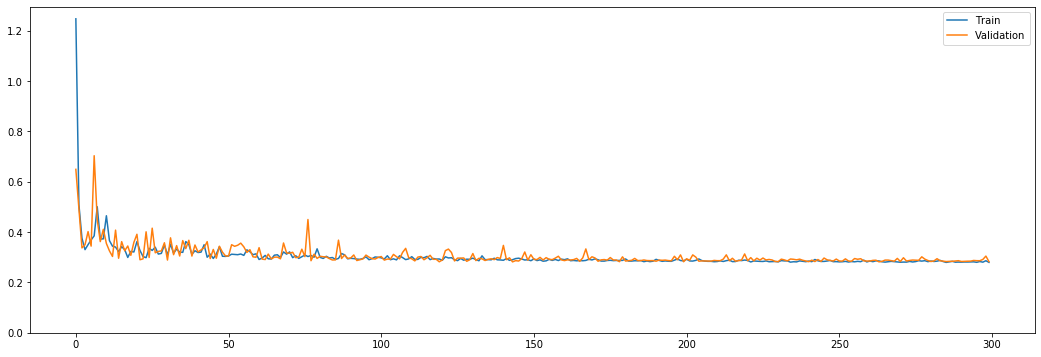

In [54]:
plot_loss(history_dist)

### Compare loss

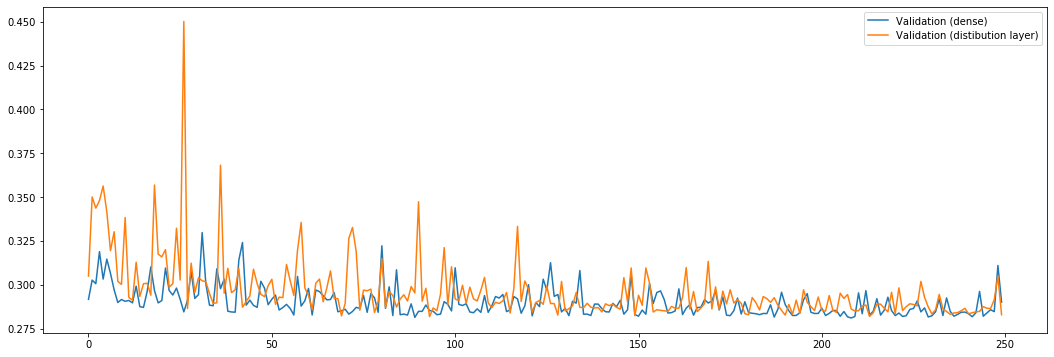

In [57]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
start_step = 50

# ax.plot(history.history['loss'][start_step:], label="Train (dense)")
ax.plot(history.history['val_loss'][start_step:], label="Validation (dense)")
# ax.plot(history_dist.history['loss'][start_step:], label="Train (distibution layer)")
ax.plot(history_dist.history['val_loss'][start_step:], label="Validation (distibution layer)")
ax.legend()
plt.show()

In [58]:
# "true" quantiles
pd.Series(np.random.normal(0.75, 0.13, size=100000)).quantile(quantiles)

0.005    0.413498
0.025    0.493401
0.165    0.622623
0.250    0.661850
0.500    0.749371
0.750    0.837662
0.835    0.876794
0.975    1.005570
0.995    1.085325
dtype: float64

In [59]:
# "true" quantiles
pd.Series(np.random.normal(1.5, 0.25, size=100000)).quantile(quantiles)

0.005    0.850479
0.025    1.010355
0.165    1.256780
0.250    1.331550
0.500    1.499606
0.750    1.669666
0.835    1.744608
0.975    1.985887
0.995    2.137708
dtype: float64

**Result**: The toy dataset contains two simple distributions, with either $\mu=0.75, \sigma=0.13$ or $\mu=1.5, \sigma=0.25$, depending on whether it is a weekday or weekend. The observed 'demand' are samples distributed as such. For these simple distributions, the Pinball Loss is able to (approximately) retrieve the correct quantiles!